<a href="https://colab.research.google.com/github/madenni/NN-DIP/blob/main/NS6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №6. Проектирование автоэнкодеров для решения прикладных задач**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1KfCEQly5k0PUdCR1w-my2-QmYfFexdvK?usp=sharing)

# Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

* **Чем больше объектов разных классов будет в исходном датасете, тем универсальнее будет работа обученной Вами модели**

> Например, если в Вашем датасете только кошки, то все объекты кроме кошек будут колоризоваться некорректно. Соответственно следует очень тщательно подойти к выбору датасета. 

  * Для решения данной задачи может подойти датасет [CIFAR-100](https://www.kaggle.com/datasets/fedesoriano/cifar100), но его минус заключается в том, что разрешение изображений довольно низкое

* Хорошим вариантом будет использование датасета [ImageNet](https://paperswithcode.com/dataset/imagenet), но ввиду его объёмности, процесс обучения займет большое количество времени, поэтому Вы можете использовать одну из его [сокращенных версий](https://www.kaggle.com/datasets/ifigotin/imagenetmini-1000)

 **Конечный выбор датасета осуществляется по Вашему желанию, учитывая рекомендации приведенные выше.**


In [ ]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import cv2
import os

In [ ]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16() # Импортируем предобученную модель VGG16 с параметрами по умолчанию
newmodel = Sequential() # Создаём пустую модель

for i, layer in enumerate(vggmodel.layers): # Заполняем пустую модель слоями из предобученной модели VGG16 
    if i<19:          # Только до 19-го слоя, чтобы включить только слои, используемые для извлечения признаков
      newmodel.add(layer)

newmodel.summary()

553467096/553467096 [==============================] - 15s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                      

In [ ]:
for layer in newmodel.layers:
  layer.trainable=False   # Мы не хотим снова обучать эти слои, поэтому False. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/animal'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=100, class_mode=None)

print(train)

Found 300 images belonging to 4 classes.


In [ ]:
print(train[0].shape)

(100, 224, 224, 3)


In [ ]:
X =[]
Y =[]

for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128) # Значения A и B находятся в диапазоне от -127 до 128, 
      # поэтому мы делим значения на 128, чтобы ограничить значения от -1 до 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #размерности должны быть одинаковыми для X и Y
print(X.shape)
print(Y.shape)
print(train[0].shape)

(100, 224, 224, 1)
(100, 224, 224, 2)
(100, 224, 224, 3)


In [ ]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  sample = keras.applications.vgg16.preprocess_input(sample)
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

1/1 [==============================] - 0s 28ms/step
(100, 7, 7, 512)


In [ ]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()


model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)       

In [ ]:
model.fit(vggfeatures, Y, verbose=1, epochs=1000, batch_size=256)

model.save('/content/colorize_autoencoder_VGG16.h5')

Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 0.7117 - accuracy: 0.7267
Epoch 2/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.8646 - accuracy: 0.2856
Epoch 3/1000
1/1 [==============================] - 0s 84ms/step - loss: 1.0173 - accuracy: 0.6276
Epoch 4/1000
1/1 [==============================] - 0s 97ms/step - loss: 0.7489 - accuracy: 0.7099
Epoch 5/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.6916 - accuracy: 0.7198
Epoch 6/1000
1/1 [==============================] - 0s 92ms/step - loss: 0.8290 - accuracy: 0.7297
Epoch 7/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.8104 - accuracy: 0.7291
Epoch 8/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.7152 - accuracy: 0.7220
Epoch 9/1000
1/1 [==============================] - 0s 76ms/step - loss: 0.4631 - accuracy: 0.7056
Epoch 10/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.1998 - accuracy: 0.6322
Epoch 11/10

In [ ]:

testpath = '/content/drive/MyDrive/animal/frog/'
files = os.listdir(testpath)
for idx, file in enumerate(files):
    # Нормализация
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    L = keras.applications.vgg16.preprocess_input(L)
    # Предсказание
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)

    # Формирование выходного изображения
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab

    # Сохранение выходного изображения
    imsave('/content/'+str(idx)+".jpg", lab2rgb(cur))

1/1 [==============================] - 0s 298ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 33 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 635 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 96 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 6 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 8 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 45 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 346 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 85 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 36 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 421 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 666 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 160 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 357 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 228 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 29 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 69 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 13 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1518 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 53 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 49 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 132 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 14 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 30ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 214 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 88 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2133 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 56 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 40ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 16 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 32 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)


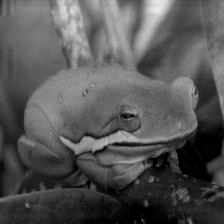

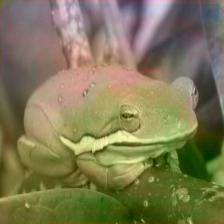

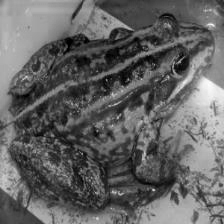

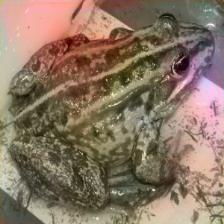

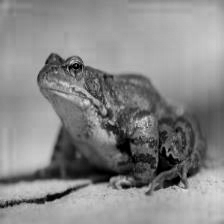

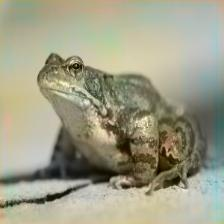

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

imo_1 = cv2.imread("/content/12.jpg")
im_1 = imo_1[:,:,0]
imo_2 = cv2.imread("/content/17.jpg")
im_2 = imo_2[:,:,0]
imo_3 = cv2.imread("/content/22.jpg")
im_3 = imo_3[:,:,0]


cv2_imshow(im_1)
cv2_imshow(imo_1)
cv2_imshow(im_2)
cv2_imshow(imo_2)
cv2_imshow(im_3)
cv2_imshow(imo_3)

# Image.open("/content/19.jpg").convert("L")

In [ ]:

testpath = '/content/drive/MyDrive/animal/testfrog/'
files = os.listdir(testpath)
for idx, file in enumerate(files):
    # Нормализация
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    L = keras.applications.vgg16.preprocess_input(L)
    # Предсказание
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)

    # Формирование выходного изображения
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab

    # Сохранение выходного изображения
    imsave('/content/result'+str(idx)+'.jpg', lab2rgb(cur))

1/1 [==============================] - 0s 21ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 334 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 63 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 254 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1607 pixels
  return func(*args, **kwargs)


1/1 [==============================] - 0s 18ms/step


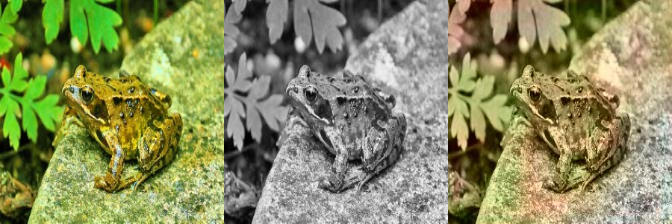

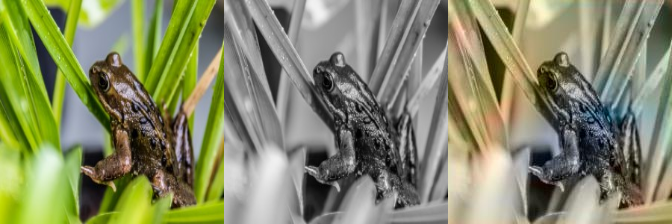

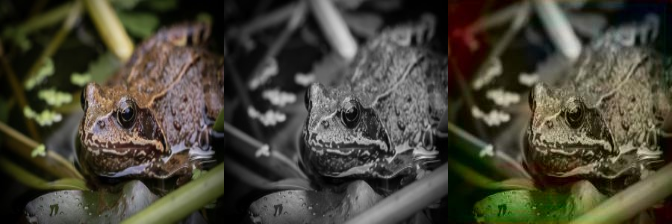

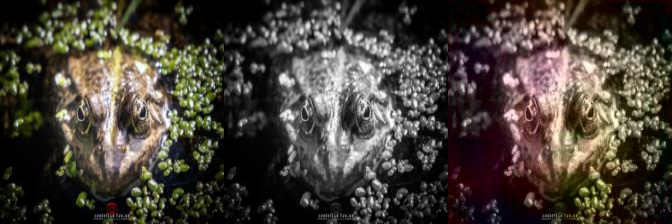

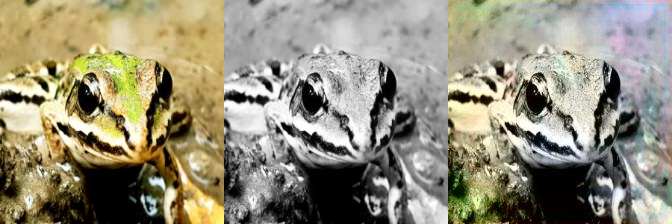

In [ ]:
def result_img(src_1, src_2):
  imo_5 = cv2.imread(src_1)
  img_5 = cv2.imread(src_2)
  img_5 = cv2.resize(img_5,(224,224), 3)
  gray1 = cv2.cvtColor(img_5, cv2.COLOR_BGR2GRAY)
  gray5 = np.zeros_like(img_5)
  gray5[:,:,0] = gray1
  gray5[:,:,1] = gray1
  gray5[:,:,2] = gray1
  pred_1 = np.concatenate((img_5, gray5, imo_5), axis=1)
  cv2_imshow(pred_1)

result_img('/content/result0.jpg','/content/drive/MyDrive/animal/testfrog/45031602372_7a16dd34fa_o.jpg')
result_img('/content/result5.jpg','/content/drive/MyDrive/animal/testfrog/44100343972_93bec0a681_o.jpg')
result_img('/content/result8.jpg','/content/drive/MyDrive/animal/testfrog/44148002084_67a728585e_o.jpg')
result_img('/content/result6.jpg','/content/drive/MyDrive/animal/testfrog/44322961294_a6f44efc55_b.jpg')
result_img('/content/result7.jpg','/content/drive/MyDrive/animal/testfrog/44527864124_9dc133183f_b.jpg')

# Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

1.  Подберите датасет, состоящий из однотипных изображений, которые в реальной жизни часто подвержены зашумлению, например спутниковые снимки, ночные фотографии и т.д.

2.  Затем примените к ним операцию зашумления и обучите модель. Также учитывайте тип шума, который Вы применяете. Он должен быть приближен к естественному.

Хороший пример реализации подобной задачи: https://www.kaggle.com/code/michalbrezk/denoise-images-using-autoencoders-tf-keras

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar100
from skimage.color import rgb2gray


def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.

    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 32, 32, 3))
    return array


def noise(array):
    """
    Добавляет случайный шум к каждому изображению в предоставленном массиве.

    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(rgb2gray(image1).reshape(32, 32, 1), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rgb2gray(image2).reshape(32, 32, 1), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

169001437/169001437 [==============================] - 14s 0us/step


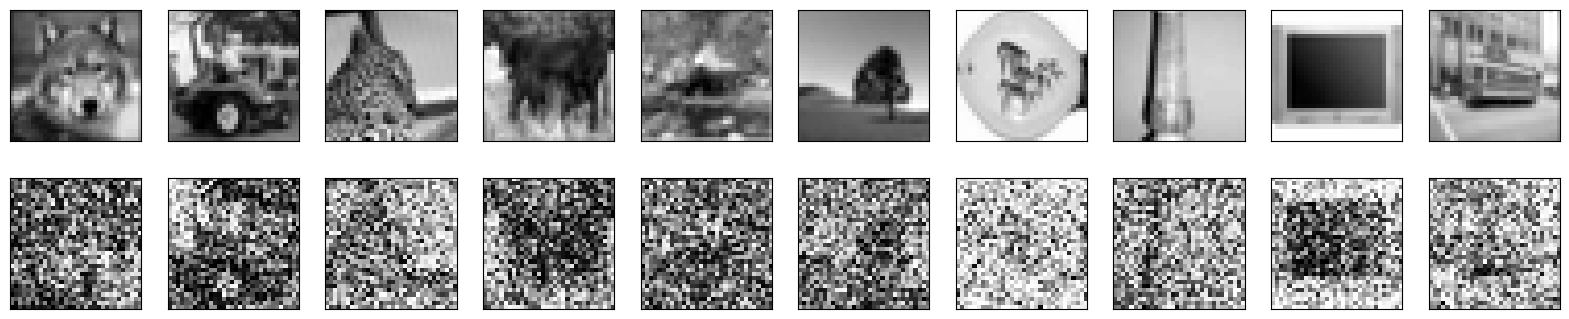

In [ ]:
# Поскольку для кодирования и декодирования нам нужны только изображения из набора данных, мы
# не будем использовать метки классов
(train_data, _), (test_data, _) = cifar100.load_data()

# Нормализация и изменение формы данных
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Создание копии данных с добавленным шумом
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Отображение данных выборки и его версии с добавленным шумом
display(train_data, noisy_train_data)

In [ ]:
input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
# x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
# x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
# x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 32)       9248      
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 3)         867       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-trainable p

In [ ]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
391/391 [==============================] - 15s 13ms/step - loss: 0.5579 - val_loss: 0.5362
Epoch 2/50
391/391 [==============================] - 4s 11ms/step - loss: 0.5352 - val_loss: 0.5324
Epoch 3/50
391/391 [==============================] - 4s 10ms/step - loss: 0.5323 - val_loss: 0.5304
Epoch 4/50
391/391 [==============================] - 4s 10ms/step - loss: 0.5308 - val_loss: 0.5293
Epoch 5/50
391/391 [==============================] - 5s 12ms/step - loss: 0.5300 - val_loss: 0.5286
Epoch 6/50
391/391 [==============================] - 4s 10ms/step - loss: 0.5294 - val_loss: 0.5282
Epoch 7/50
391/391 [==============================] - 4s 10ms/step - loss: 0.5290 - val_loss: 0.5279
Epoch 8/50
391/391 [==============================] - 4s 11ms/step - loss: 0.5287 - val_loss: 0.5275
Epoch 9/50
391/391 [==============================] - 4s 10ms/step - loss: 0.5285 - val_loss: 0.5273
Epoch 10/50
391/391 [==============================] - 4s 10ms/step - loss: 0.5283 - val_l

313/313 [==============================] - 1s 2ms/step


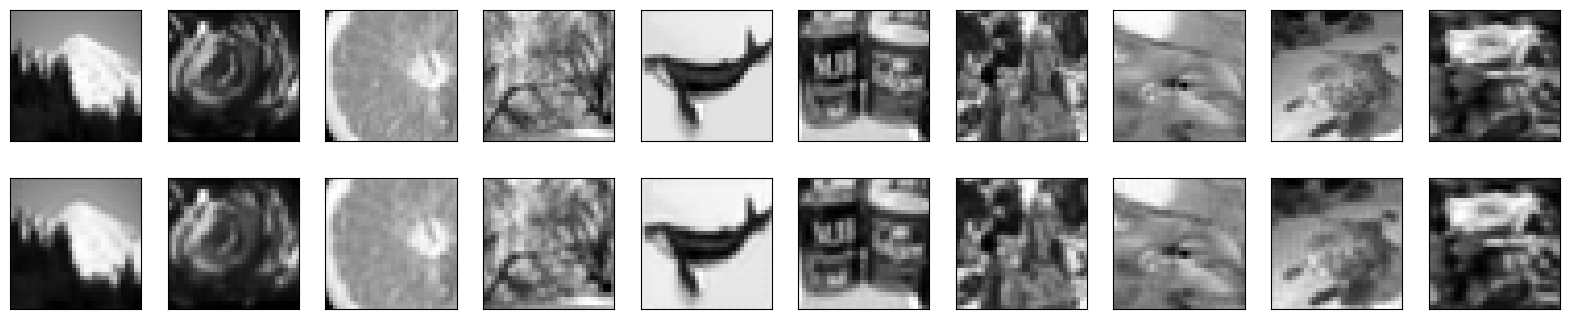

In [ ]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
391/391 [==============================] - 4s 11ms/step - loss: 0.5636 - val_loss: 0.5551
Epoch 2/100
391/391 [==============================] - 4s 10ms/step - loss: 0.5547 - val_loss: 0.5531
Epoch 3/100
391/391 [==============================] - 4s 10ms/step - loss: 0.5536 - val_loss: 0.5523
Epoch 4/100
391/391 [==============================] - 4s 10ms/step - loss: 0.5530 - val_loss: 0.5519
Epoch 5/100
391/391 [==============================] - 4s 10ms/step - loss: 0.5527 - val_loss: 0.5516
Epoch 6/100
391/391 [==============================] - 4s 11ms/step - loss: 0.5524 - val_loss: 0.5513
Epoch 7/100
391/391 [==============================] - 4s 10ms/step - loss: 0.5522 - val_loss: 0.5512
Epoch 8/100
391/391 [==============================] - 4s 10ms/step - loss: 0.5520 - val_loss: 0.5512
Epoch 9/100
391/391 [==============================] - 4s 10ms/step - loss: 0.5519 - val_loss: 0.5508
Epoch 10/100
391/391 [==============================] - 4s 10ms/step - loss: 0.551

313/313 [==============================] - 1s 2ms/step


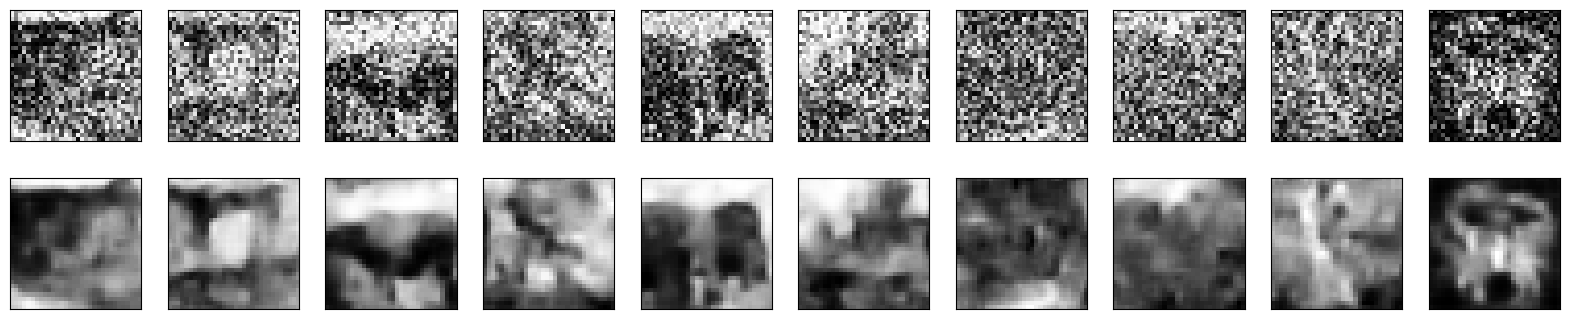

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения (апскейлинг-[определение](https://dic.academic.ru/dic.nsf/ruwiki/346555))

1. На входной слой нейронной сети подаётся изображение с размерностью (256, 256,3) - X_test. В результате работы нейронной сети на выходном слое должно получиться изображение (512, 512, 3) - Y_test. В итоге мы получаем двукратный апскейл исходного изображения.

2. Датасет собираете из изображений, разрешение которых выше эталонного (512,512,3). Затем преобразуете их в указанные размерности и формируете из них обучающую и проверочную выборку. 

3. Обучите модель. Отобразите графики обучения

4. Подумайте, каким образом можно будет адаптировать модель вашей нейронной сети для двухратного апскейла изображения с любой размерностью, большей, чем (256,256,3), с полным или частичным сохранением его исходных пропорций. Например: подаём на вход изображение с разрешением (1920, 1080, 3) - получаем изображение с разрешением (3840, 2160, 3), т.е. с полным сохранением исходных пропорций или (1792, 1024, 3) с частичным сохранением исходных пропорций.

> Подсказка: Для этого можно реализовать алгоритм предварительной обработки исходного изображения, перед подачей его в нейронную сеть

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils import paths
import cv2
from google.colab.patches import cv2_imshow

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [ ]:
def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 104, 104, 3))
    return array

In [ ]:
def display(array1, array2, n):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    indices = np.random.randint(len(array1), size=n)
    images1 = np.asarray(array1)[indices, :]
    images2 = np.asarray(array2)[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(cv2.cvtColor(image1, cv2.COLOR_RGB2BGR))

        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(cv2.cvtColor(image2, cv2.COLOR_RGB2BGR))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

0
10
20
30
40
50
60
70
74 фотографий


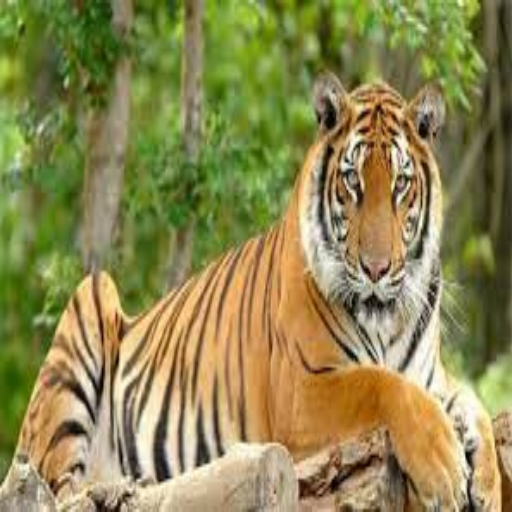

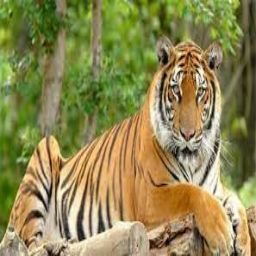

In [ ]:
images512 = []
images256 = []
i = 0
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/animal/tiger")))
n = len(imagePaths)
for i in range(75):
	if i % 10 == 0:
		print(i)	
	image = cv2.imread(imagePaths[i])
	try:
		images512.append(cv2.resize(image, (512, 512)))
		images256.append(cv2.resize(image, (256, 256)))
	except Exception as e:
		print(e)
		print('фото не обработалось',imagePaths[i])
print(i, 'фотографий')
cv2_imshow(images512[0])
cv2_imshow(images256[0])

In [ ]:
input = layers.Input(shape=(256, 256, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

from keras import optimizers

optimizer = optimizers.Adam(0.001)
# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mse', 'accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 512, 512, 64)     36928     
 ranspose)                                                       
                                                             

In [ ]:
def preprocess(array, n):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), n, n, 3))
    return array

In [ ]:
from sklearn.model_selection import train_test_split

print(np.asarray(images256).shape, np.asarray(images512).shape)
images256 = preprocess(np.asarray(images256), 256)
images512 = preprocess(np.asarray(images512), 512)

X_train, X_test, y_train, y_test = train_test_split(images256, images512, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(75, 256, 256, 3) (75, 512, 512, 3)
(60, 256, 256, 3) (15, 256, 256, 3) (60, 512, 512, 3) (15, 512, 512, 3)


In [ ]:
autoencoder.fit(
    x=X_train,
    y=y_train,
    epochs=50,
    batch_size=10,
    shuffle=True,
    validation_data=(X_test, y_test),
)

Epoch 1/50
6/6 [==============================] - 7s 530ms/step - loss: 0.0768 - mse: 0.0768 - accuracy: 0.4653 - val_loss: 0.0836 - val_mse: 0.0836 - val_accuracy: 0.4315
Epoch 2/50
6/6 [==============================] - 2s 291ms/step - loss: 0.0730 - mse: 0.0730 - accuracy: 0.4879 - val_loss: 0.0790 - val_mse: 0.0790 - val_accuracy: 0.4211
Epoch 3/50
6/6 [==============================] - 2s 263ms/step - loss: 0.0682 - mse: 0.0682 - accuracy: 0.5022 - val_loss: 0.0709 - val_mse: 0.0709 - val_accuracy: 0.4129
Epoch 4/50
6/6 [==============================] - 2s 290ms/step - loss: 0.0582 - mse: 0.0582 - accuracy: 0.5009 - val_loss: 0.0529 - val_mse: 0.0529 - val_accuracy: 0.4127
Epoch 5/50
6/6 [==============================] - 2s 262ms/step - loss: 0.0371 - mse: 0.0371 - accuracy: 0.5010 - val_loss: 0.0247 - val_mse: 0.0247 - val_accuracy: 0.4076
Epoch 6/50
6/6 [==============================] - 2s 275ms/step - loss: 0.0205 - mse: 0.0205 - accuracy: 0.4964 - val_loss: 0.0140 - val_mse

2/2 [==============================] - 7s 3s/step
(256, 256, 3) (512, 512, 3)


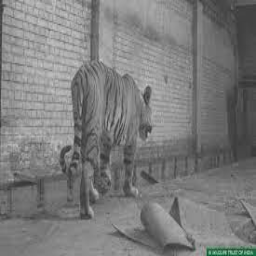

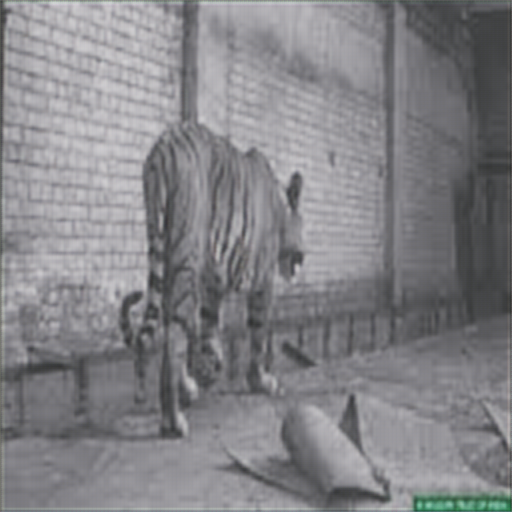

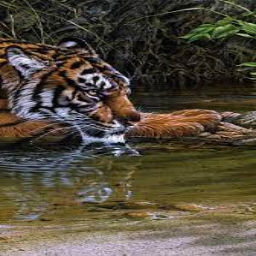

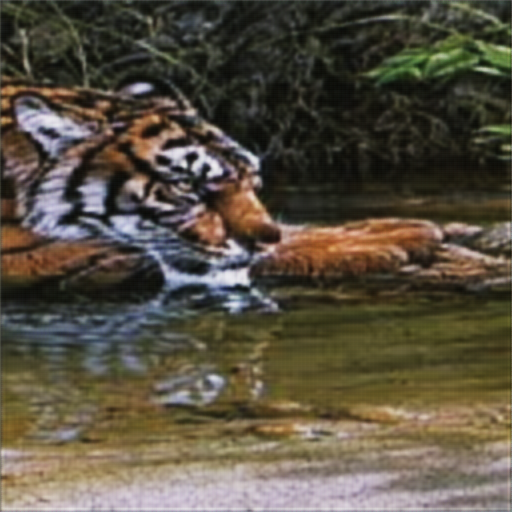

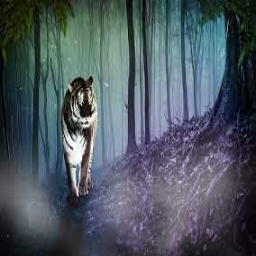

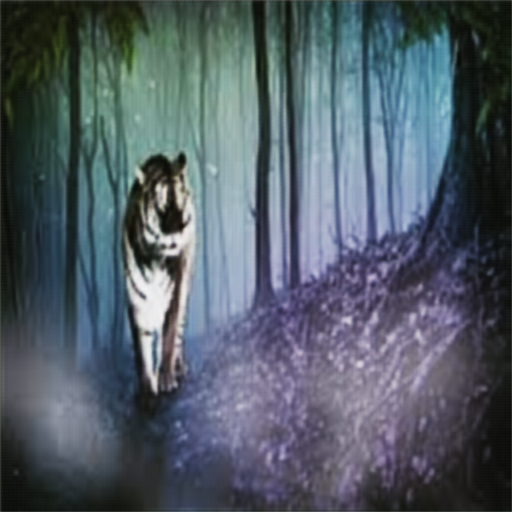

In [ ]:
predictions = autoencoder.predict(X_train)
print(X_train[0].shape,predictions[0].shape)
for i in range(3):
  cv2_imshow(X_train[i]*255.0)
  cv2_imshow(predictions[i]*255.0)

3 фотографий


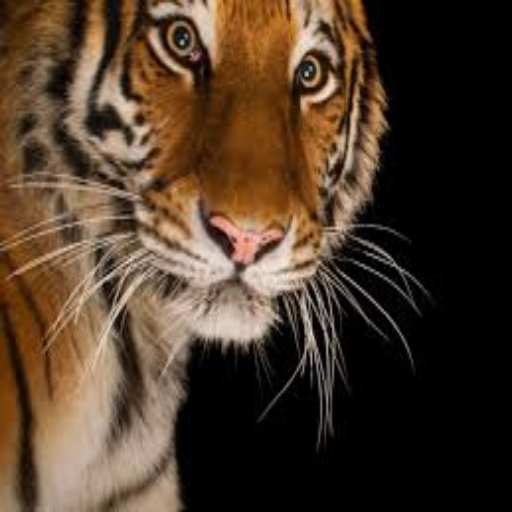

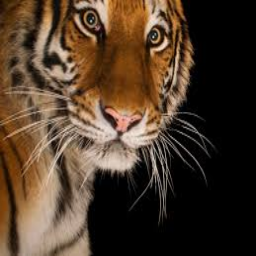

In [ ]:
images512 = []
images256 = []
i = 0
imagePaths = sorted(list(paths.list_images("/content/photos")))
n = len(imagePaths)
for i in range(4):
  image = cv2.imread(imagePaths[i])
  try:
    images512.append(cv2.resize(image, (512, 512)))
    images256.append(cv2.resize(image, (256, 256)))
  except Exception as e:
    print(e)
    print('фото не обработалось',imagePaths[i])
print(i, 'фотографий')
cv2_imshow(images512[0])
cv2_imshow(images256[0])

In [ ]:
def preprocess(array, n):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), n, n, 3))
    return array
images256 = preprocess(np.asarray(images256), 256)
images512 = preprocess(np.asarray(images512), 512)

1/1 [==============================] - 1s 820ms/step


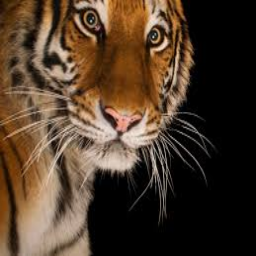

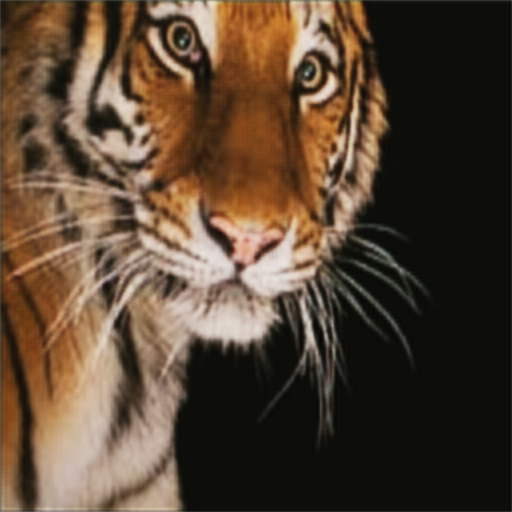

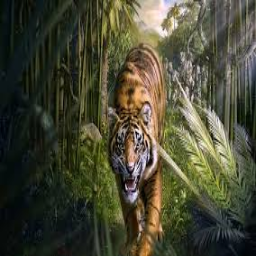

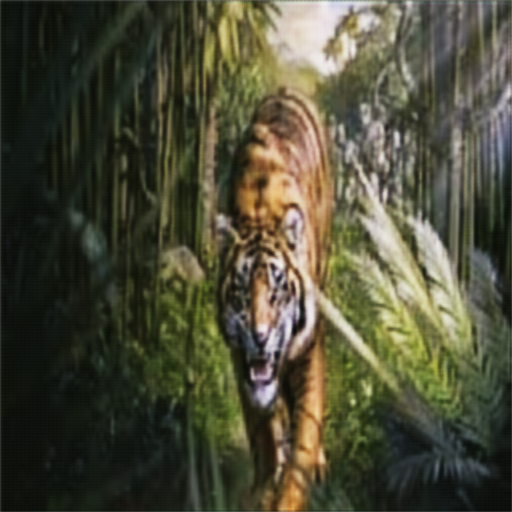

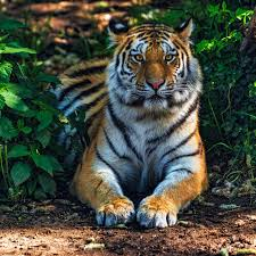

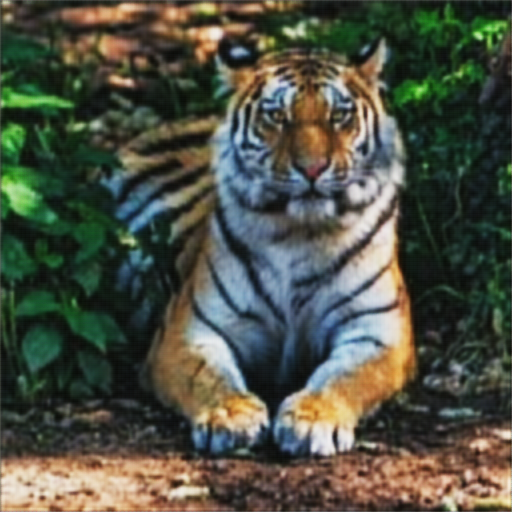

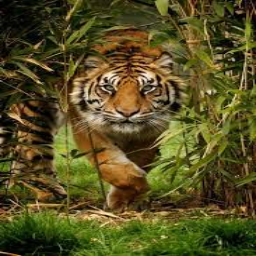

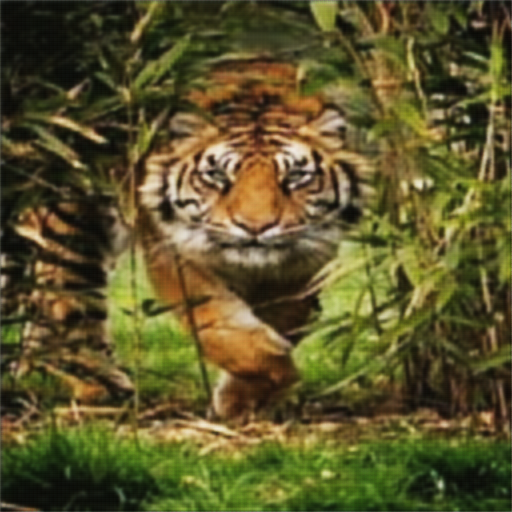

In [ ]:
predictions = autoencoder.predict(images256)
for i in range(4):
  cv2_imshow(images256[i]*255.0)
  cv2_imshow(predictions[i]*255.0)